# Gene essentiality

In [2]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import bacillusme
from bacillusme import (transcription, translation, flat_files, generics, formulas, compartments)
from bacillusme.util.helper_functions import *

import matplotlib.pyplot as plt 

%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(bacillusme.__file__)

/home/jt/Downloads/cobrapy-0.5.11/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/Downloads/cobrapy-0.5.11/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/Downloads/cobrapy-0.5.11/cobra/__init__.py
/home/jt/UCSD/cobrame-master/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/bacillusme/__init__.py


In [33]:
def get_genes_of_me(me):
    genes = [m.id.split('_')[1] for m in me.metabolites if isinstance(m,cobrame.TranslatedGene)]
    if 'dummy' in genes:
        genes.remove('dummy')
    return list(set(genes))

In [4]:
eco_directory = join(flat_files.ecoli_files_dir, 'iJO1366.json')
ijo_directory = join(flat_files.ecoli_files_dir, 'iYO844.json')
uni_directory = join(flat_files.ecoli_files_dir, 'universal_model.json')

eco = cobra.io.load_json_model(eco_directory)
bsub = cobra.io.load_json_model(ijo_directory)
uni = cobra.io.load_json_model(uni_directory)

bsub.optimize()

<Solution 0.12 at 0x7f90c95b8518>

In [5]:
with open('../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)
with open('../me_models/final/iJL1678b.pickle', 'rb') as f:
    ecome = pickle.load(f)

## Essentiality

M-model

In [11]:
from bacillusme.analysis import essentiality as es

In [5]:
genes = [gene.id for gene in bsub.genes]
essentiality_df_m,flux_responses_m = es.gene_essentiality(bsub,genes, 'm',NP=10,threshold = 0.01,precision=1e-6)
flux_responses_m.to_csv('essentiality/essentiality_raw_results.csv')

10 threads:   0%|          | 0/844 [00:00<?, ?it/s]

Solving model for base solution


10 threads: 100%|██████████| 844/844 [00:58<00:00,  9.49it/s]

Done


In [68]:
# E. coli
genes = [gene.id for gene in eco.genes]
essentiality_df_m,flux_responses_m = es.gene_essentiality(eco,genes, 'm',NP=10,threshold = 0.01,precision=1e-6)
flux_responses_m.to_csv('essentiality/essentiality_raw_results_eco.csv')

10 threads:   0%|          | 0/1367 [00:00<?, ?it/s]

Solving model for base solution


10 threads: 100%|█████████▉| 1366/1367 [03:15<00:00,  9.03it/s]

Done


ME-model

In [ ]:
genes = [gene.id for gene in me.genes]
essentiality_df_me,flux_responses_me = es.gene_essentiality(me,genes,'me',NP=10,threshold = 0.01,precision=1e-6)
flux_responses_me.to_csv('essentiality/essentiality_raw_me_results.csv')

Solving model for base solution


10 threads: 100%|██████████| 844/844 [01:10<00:00,  9.49it/s]

In [ ]:
# E. coli
genes_eco = get_genes_of_me(ecome)
essentiality_df_me,flux_responses_me = es.gene_essentiality(ecome,genes_eco,'me',NP=10,threshold = 0.01,precision=1e-6)
flux_responses_me.to_csv('essentiality/essentiality_raw_me_results_eco.csv')

Solving model for base solution



10 threads:   1%|          | 10/1569 [36:57<56:13:05, 129.82s/it]

In [70]:
# Read
flux_responses_m = pd.read_csv('essentiality/essentiality_raw_results.csv',index_col=0)
flux_responses_me = pd.read_csv('essentiality/essentiality_raw_me_results.csv',index_col=0)

flux_responses_m_eco = pd.read_csv('essentiality/essentiality_raw_results_eco.csv',index_col=0)
flux_responses_me_eco = pd.read_csv('essentiality/essentiality_raw_me_results_eco.csv',index_col=0)

In [72]:
essentiality_df_m,_ = es.gene_essentiality(bsub,genes,'m',flux_responses=flux_responses_m)
essentiality_df_me,_ = es.gene_essentiality(me,genes,'me',flux_responses=flux_responses_me)

essentiality_df_m_eco,_ = es.gene_essentiality(eco,genes_eco,'m',flux_responses=flux_responses_m_eco)
essentiality_df_me_eco,_ = es.gene_essentiality(ecome,genes_eco,'me',flux_responses=flux_responses_me_eco)

Done
Done
Done
Done


### Combine results

In [73]:
essentiality_df = essentiality_df_me.join(essentiality_df_m,lsuffix='_me',rsuffix='_m')
essentiality_df_eco = essentiality_df_me_eco.join(essentiality_df_m_eco,lsuffix='_me',rsuffix='_m')

## M/ME comparison

In [76]:
difference_df = essentiality_df[essentiality_df.essentiality_m != essentiality_df.essentiality_me].dropna()
difference_df_eco = essentiality_df_eco[essentiality_df_eco.essentiality_m != essentiality_df_eco.essentiality_me].dropna()

In [77]:
difference_df_eco

,response_me,essentiality_me,response_m,essentiality_m
b0084,1.423161,+,0.000000,0
b0351,-0.553186,-,0.000000,0
b3747,-0.023486,-,0.000000,0
b0243,-0.378763,-,-0.000916,0
b2601,1.643464,+,0.000000,0
...,...,...,...,...
b3829,-1.000000,e,0.000000,0
b3956,1.552055,+,-0.003059,0
b0727,2.261684,+,-0.004733,0
b2779,-1.000000,e,-0.078823,-


## Reported essentiality

In [78]:
gene_dictionary = pd.read_csv('../building_data/gene_name_dictionary.csv',index_col=0)
essential_genes = pd.read_csv('./essentiality/subtiwiki_essential.txt',index_col=0,sep='\t')
essential_genes_eco = pd.read_csv('./essentiality/eco_essential.txt',index_col=3,sep='\t')

In [105]:
def get_gene_count(me):
    from Bio import SeqIO
    gb_file = SeqIO.read("../building_data/NC_000964.gb", 'gb')
    gene_count = 0
    for feature in gb_file.features:
        if feature.type not in {'CDS', 'rRNA','tRNA', 'ncRNA'}:
            continue
        gene_count += 1
    return gene_count

In [106]:
gene_count = get_gene_count("../building_data/NC_000964.gb")
gene_count_eco = get_gene_count("../building_data/NC_000913.2.gb")

In [80]:
all_genes = get_genes_of_me(me)
all_genes_eco = get_genes_of_me(ecome)

In [81]:
def get_true_essentiality(essential_genes,all_genes,gene_dictionary=False):
    true_essentiality = {}
    for locus_id in all_genes:
        if isinstance(gene_dictionary,pd.DataFrame):
            name = gene_dictionary.loc[locus_id]['name']
        else:
            name = locus_id
        if name in essential_genes.index.values:
            true_essentiality[locus_id] = 'e'
        else:
            true_essentiality[locus_id] = 0
    true_essentiality_df = pd.DataFrame({'true_essentiality':true_essentiality})
    return true_essentiality_df

In [90]:
essentiality_df

,response_me,essentiality_me,response_m,essentiality_m
BSU00140,0.000000,0,-2.150779e-10,0
BSU00180,0.000000,0,-2.960415e-06,0
BSU00150,-0.000234,0,-9.729447e-05,0
BSU00090,0.000000,0,-3.719203e-10,0
BSU00270,0.000000,0,-1.300703e-10,0
...,...,...,...,...
BSU41060,-1.000000,e,NaN,NaN
BSU40550,-1.000000,e,-1.000000e+00,e
BSU40910,-1.000000,e,NaN,NaN
BSU40420,-1.000000,e,-1.000000e+00,e


In [89]:
true_essentiality_df

,true_essentiality
BSU00090,0
BSU00110,0
BSU00120,0
BSU00130,e
BSU00140,0
...,...
BSU40850,0
BSU40890,e
BSU40910,0
BSU41050,e


In [91]:
true_essentiality_df = get_true_essentiality(essential_genes,all_genes,gene_dictionary=gene_dictionary)
true_essentiality_df_eco = get_true_essentiality(essential_genes_eco,all_genes_eco,gene_dictionary=False)

In [92]:
essentiality_df = essentiality_df.join(true_essentiality_df)
essentiality_df_eco = essentiality_df_eco.join(true_essentiality_df_eco)

In [93]:
essentiality_df.to_csv('essentiality/essentiality_results.csv')
essentiality_df_eco.to_csv('essentiality/essentiality_results_eco.csv')

### Read

In [94]:
# Read
essentiality_df = pd.read_csv('essentiality/essentiality_results.csv',index_col=0)
essentiality_df_eco = pd.read_csv('essentiality/essentiality_results_eco.csv',index_col=0)

In [111]:
def get_scores(essentiality_df,gene_count):
    models = ['m','me']
    scores = {}
    for m in models:
        scores[m] = {}

        field = 'essentiality_{}'.format(m)
        P = essentiality_df[(essentiality_df[field]=='e')].shape[0]
        N = essentiality_df[(essentiality_df[field]=='0')].shape[0]
        TP = essentiality_df[essentiality_df[field]=='e'][essentiality_df.true_essentiality=='e'].shape[0]
        FP = P-TP
        TN = essentiality_df[essentiality_df[field]=='0'][essentiality_df.true_essentiality=='0'].shape[0]
        FN = N-TN

        FDR = FP/(FP+TP)
        precision = TP/(TP+FP)
        TPR = TP/(TP+FN)
        MCC = (TP*TN - FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
        coverage = (P+N)/gene_count

        print(TP,FP,TN,FN)

        scores[m]['Precision'] = precision
        scores[m]['FDR'] = FDR
        scores[m]['TPR'] = TPR
        scores[m]['MCC'] = MCC
        scores[m]['Coverage'] = coverage

    scores_df = pd.DataFrame.from_dict(scores)
    return scores_df

In [112]:
scores_df = get_scores(essentiality_df,gene_count)
scores_df_eco = get_scores(essentiality_df_eco,gene_count_eco)

57 117 567 23
143 168 592 20
92 110 972 141
232 177 900 98


/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/ipykernel_launcher.py:10 UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/ipykernel_launcher.py:12 UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Text(0, 0.5, 'Score')

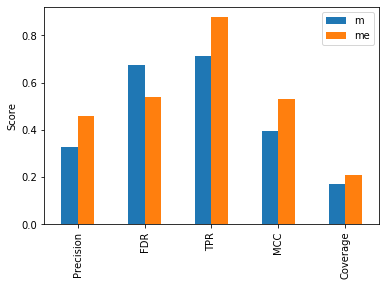

In [119]:
scores_df.plot.bar()
plt.ylabel('Score')

Text(0, 0.5, 'Score')

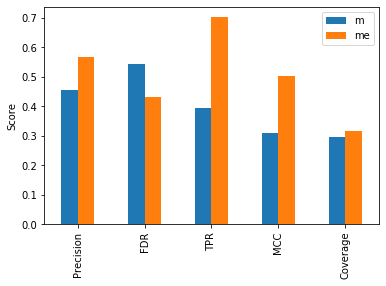

In [120]:
scores_df_eco.plot.bar()
plt.ylabel('Score')

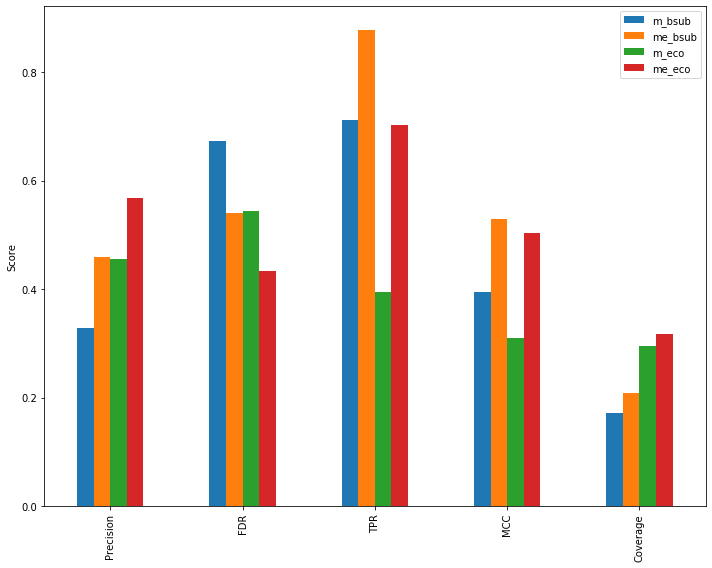

In [122]:
all_scores_df = scores_df.join(scores_df_eco,lsuffix='_bsub',rsuffix='_eco')
all_scores_df.plot.bar(figsize=(10,8))
plt.ylabel('Score')
plt.savefig('essentiality/essentiality_scores.svg',format='SVG')
plt.tight_layout()